In [1]:
import numpy as np
import awkward as ak
import uproot_methods

In [2]:
import logging
logging.basicConfig(level=logging.INFO, format='[%(asctime)s] %(levelname)s: %(message)s')

In [3]:
def pad_array(a, maxlen, value=0., dtype='float32'):
    x = (np.ones((len(a), maxlen)) * value).astype(dtype)
    for idx, s in enumerate(a):
#         print(s)
        if not len(s):
            continue
        trunc = s[:maxlen].astype(dtype)
        x[idx, :len(trunc)] = trunc
    return x

In [4]:
##and Professor suggests that we could use mass, classifacation for later application
def SetAKArr(filepath):
    with open(filepath, 'r') as file:
        lines = file.readlines()
    prtclsdata = []
    prtclsexp = []
    _label1 = []
    _label2 = []
    _label3 = []
    _label4 = []
    _label5 = []
    
    dirty = 0
    first = 1
    #record the number of particles in one experiment
    for line in lines:
        if line.startswith('E'):
            if (prtclsdata and not dirty):
                prtclsexp.append(prtclsdata)
                exp_inf = line.split()
                _label1.append(float(exp_inf[1]))
                _label2.append(float(exp_inf[2]))
                _label3.append(float(exp_inf[3]))
                _label4.append(float(exp_inf[4]))
                _label5.append(float(exp_inf[5]))
            elif (not prtclsdata and first):
                exp_inf = line.split()
                _label1.append(float(exp_inf[1]))
                _label2.append(float(exp_inf[2]))
                _label3.append(float(exp_inf[3]))
                _label4.append(float(exp_inf[4]))
                _label5.append(float(exp_inf[5]))
            first = 0
            prtclsdata = []
            dirty = 0
        else:
            #we ignore the photon
            par = line.split()
            if (int(par[1]) == 22):
                dirty = 1
            if (not dirty):
#                 no photon
                prtclsdata.append(float(par[2]))
                prtclsdata.append(float(par[3]))
                prtclsdata.append(float(par[4]))
                prtclsdata.append(float(par[5]))
                prtclsdata.append(float(par[6]))
                prtclsdata.append(int(par[0]))
#                 prtclsdata.append(int(par[1]))
    if (prtclsdata and not dirty):
        prtclsexp.append(prtclsdata)
    ##Create an Order Dic

    from collections import OrderedDict
    v = OrderedDict()
    prtclsexp_arr = np.array(prtclsexp)
    expinf = ak.JaggedArray.fromiter(prtclsexp_arr)
    v['allparticlesdata'] = expinf
    v['label'] = np.stack(_label5, axis = -1)
    return v

In [5]:
class Dataset(object):
    def __init__(self, filepath, feature_dict = {}, label = 'label', pad_len=18, data_format='channel_first'):
        self.filepath = filepath
        self.feature_dict = feature_dict
        if len(feature_dict) == 0:
#             feature_dict['points'] = ['part_energy', 'part_mass']
            feature_dict['features'] = ['allparticlesdata']
#             feature_dict['mask'] = ['part_energy']
        ##currently we use 'E' for experiments
        self.label = label
        self.pad_len = pad_len
        assert data_format in ('channel_first', 'channel_last')
        self.stack_axis = 1 if data_format=='channel_first' else -1
        self._values = {}
        self._label = None
        self._load()
        
    def _load(self):
        logging.info('Start loading file %s' % self.filepath)
        a = SetAKArr(self.filepath)
        self._label = a[self.label]
        for k in self.feature_dict:
                cols = self.feature_dict[k]
                if not isinstance(cols, (list, tuple)):
                    cols = [cols]
                arrs = []
                for col in cols:
                    arrs.append(pad_array(a[col], self.pad_len))
#                     print(pad_array(a[col], self.pad_len))
#                     print(type(a[col]))
                    ##check the dimesion of a[col], and it should be array.
                self._values[k] = np.stack(arrs, axis=self.stack_axis)
        logging.info('Finished loading file %s' % self.filepath)
        
    def __len__(self):
        return len(self._label)

    def __getitem__(self, key):
        if key==self.label:
            return self._label
        else:
            return self._values[key]
    
    @property
    def X(self):
        return self._values
    
    @property
    def y(self):
        return self._label

    def shuffle(self, seed=None):
        if seed is not None:
            np.random.seed(seed)
        shuffle_indices = np.arange(self.__len__())
        np.random.shuffle(shuffle_indices)
        for k in self._values:
            self._values[k] = self._values[k][shuffle_indices]
        self._label = self._label[shuffle_indices]

In [6]:
train_dataset = Dataset('train.txt', data_format='channel_last')
val_dataset = Dataset('val.txt', data_format='channel_last')
test_dataset = Dataset('test.txt', data_format = 'channel_last')

[2024-06-22 00:15:25,640] INFO: Start loading file train.txt
[2024-06-22 00:15:27,558] INFO: Finished loading file train.txt
[2024-06-22 00:15:27,559] INFO: Start loading file val.txt
[2024-06-22 00:15:27,795] INFO: Finished loading file val.txt
[2024-06-22 00:15:27,796] INFO: Start loading file test.txt
[2024-06-22 00:15:28,039] INFO: Finished loading file test.txt


In [7]:
import tensorflow as tf
from tensorflow import keras
from tf_keras_model import get_particle_net, get_particle_net_lite
from simpleModel import get_simple_model

In [8]:
# model_type = 'particle_net_lite' # choose between 'particle_net' and 'particle_net_lite'
##this shows the number of classes for classification
try:
    num_classes = train_dataset.y.shape[1]
except:
    num_classes = 1
input_shapes = {k:train_dataset[k].shape[1:] for k in train_dataset.X}
# # print(input_shapes)
# for k in train_dataset.X:
#     print(k)
#     print(train_dataset[k].shape)
# if 'lite' in model_type:
#     model = get_particle_net_lite(num_classes, input_shapes)
# else:
# model = get_particle_net(num_classes, input_shapes)
simple_model = get_simple_model(num_classes, input_shapes)

In [9]:
# Training parameters
batch_size = 384
epochs = 200

In [10]:
def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 10:
        lr *= 0.1
    elif epoch > 20:
        lr *= 0.01
    logging.info('Learning rate: %f'%lr)
    return lr

In [11]:
simple_model.compile(loss='mean_squared_error',
              optimizer=keras.optimizers.Adam(learning_rate=lr_schedule(200)),
#               optimizer=keras.optimizers.Adam(learning_rate=),
              metrics=['accuracy'])
simple_model.summary()

[2024-06-22 00:15:35,609] INFO: Learning rate: 0.000100


Model: "Simple_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
features (InputLayer)        [(None, 18, 1)]           0         
_________________________________________________________________
flatten (Flatten)            (None, 18)                0         
_________________________________________________________________
dense (Dense)                (None, 128)               2432      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 2,561
Trainable params: 2,561
Non-trainable params: 0
_________________________________________________________________


In [12]:
from tensorflow.keras.callbacks import Callback
class LossLogger(Callback):
    def __init__(self, filename):
        super().__init__()
        self.filename = filename
#         self.lb = lb

    def on_epoch_end(self, epoch, logs=None):
        with open(self.filename, 'a') as f:
#             print("Epoch ", epoch + 1,": loss = ", logs["val_loss"], "\n", file = f)
#             if (epoch+1)%5==0 or epoch==0:
            print('V ', logs['val_loss'], file = f)
            print('L', logs['loss'], file = f)
#             print()
#             f.write()
# loss_logger = LossLogger('MSE_vac_loss.txt')
loss_logger = LossLogger('MSE_loss.txt')

In [19]:
# Prepare model model saving directory.
import os
save_dir = 'model_checkpoints'
model_name = 'simple_model.{epoch:03d}.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = keras.callbacks.ModelCheckpoint(filepath='loss.txt',
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)
# I change the monitor from val_acc to val_loss
# checkpoint = keras.callbacks.ModelCheckpoint(filepath=filepath,
#                              monitor='val_loss',
#                              verbose=1,
#                              save_best_only=True)
lr_scheduler = keras.callbacks.LearningRateScheduler(lr_schedule)
progress_bar = keras.callbacks.ProgbarLogger()
callbacks = [checkpoint, lr_scheduler, loss_logger]
# callbacks = [lr_schedule]

In [20]:
train_dataset.shuffle()
simple_model.fit(train_dataset.X, train_dataset.y,
          batch_size=batch_size,
#           epochs=epochs,
          epochs=200,
          validation_data=(val_dataset.X, val_dataset.y),
          shuffle=True,
          callbacks=callbacks
            )

[2024-06-20 17:35:14,786] INFO: Learning rate: 0.001000


Epoch 1/200
106/144 [=====================>........] - ETA: 0s - loss: 0.0044 - accuracy: 0.0000e+00    

[2024-06-20 17:35:14,888] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 692us/step - loss: 0.0032 - accuracy: 0.0000e+00 - val_loss: 1.0484e-04 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:14,890] INFO: Learning rate: 0.001000


Epoch 2/200
 87/144 [=================>............] - ETA: 0s - loss: 9.6076e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:14,982] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 639us/step - loss: 9.2018e-05 - accuracy: 0.0000e+00 - val_loss: 7.8508e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:14,984] INFO: Learning rate: 0.001000


Epoch 3/200
 87/144 [=================>............] - ETA: 0s - loss: 7.8176e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:15,098] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 789us/step - loss: 7.5490e-05 - accuracy: 0.0000e+00 - val_loss: 6.9435e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:15,100] INFO: Learning rate: 0.001000


Epoch 4/200
101/144 [====================>.........] - ETA: 0s - loss: 6.3212e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:15,195] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 659us/step - loss: 6.1638e-05 - accuracy: 0.0000e+00 - val_loss: 5.7488e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:15,197] INFO: Learning rate: 0.001000


Epoch 5/200
 98/144 [===================>..........] - ETA: 0s - loss: 5.4325e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:15,291] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 654us/step - loss: 5.3670e-05 - accuracy: 0.0000e+00 - val_loss: 4.8701e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:15,294] INFO: Learning rate: 0.001000


Epoch 6/200
 80/144 [===============>..............] - ETA: 0s - loss: 5.0286e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:15,395] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 695us/step - loss: 5.0590e-05 - accuracy: 0.0000e+00 - val_loss: 4.8354e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:15,397] INFO: Learning rate: 0.001000


Epoch 7/200
 93/144 [==================>...........] - ETA: 0s - loss: 4.9161e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:15,508] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 761us/step - loss: 4.8359e-05 - accuracy: 0.0000e+00 - val_loss: 4.7793e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:15,509] INFO: Learning rate: 0.001000


Epoch 8/200
 98/144 [===================>..........] - ETA: 0s - loss: 4.6366e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:15,597] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 606us/step - loss: 4.6128e-05 - accuracy: 0.0000e+00 - val_loss: 4.5971e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:15,599] INFO: Learning rate: 0.001000


Epoch 9/200
 96/144 [===================>..........] - ETA: 0s - loss: 4.5902e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:15,688] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 613us/step - loss: 4.5764e-05 - accuracy: 0.0000e+00 - val_loss: 4.4176e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:15,690] INFO: Learning rate: 0.001000


Epoch 10/200
 98/144 [===================>..........] - ETA: 0s - loss: 4.4684e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:15,780] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 628us/step - loss: 4.5035e-05 - accuracy: 0.0000e+00 - val_loss: 4.4108e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:15,782] INFO: Learning rate: 0.001000


Epoch 11/200
 89/144 [=================>............] - ETA: 0s - loss: 4.4957e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:15,877] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 655us/step - loss: 4.4546e-05 - accuracy: 0.0000e+00 - val_loss: 4.7230e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:15,879] INFO: Learning rate: 0.000100


Epoch 12/200
101/144 [====================>.........] - ETA: 0s - loss: 3.9059e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:15,967] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 611us/step - loss: 3.8526e-05 - accuracy: 0.0000e+00 - val_loss: 3.9479e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:15,969] INFO: Learning rate: 0.000100


Epoch 13/200
 96/144 [===================>..........] - ETA: 0s - loss: 3.7732e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:16,063] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 650us/step - loss: 3.8083e-05 - accuracy: 0.0000e+00 - val_loss: 3.8945e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:16,065] INFO: Learning rate: 0.000100


Epoch 14/200
 76/144 [==============>...............] - ETA: 0s - loss: 3.7698e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:16,177] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 776us/step - loss: 3.7953e-05 - accuracy: 0.0000e+00 - val_loss: 3.8783e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:16,179] INFO: Learning rate: 0.000100


Epoch 15/200
 94/144 [==================>...........] - ETA: 0s - loss: 3.7881e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:16,271] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 632us/step - loss: 3.7866e-05 - accuracy: 0.0000e+00 - val_loss: 3.8770e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:16,272] INFO: Learning rate: 0.000100


Epoch 16/200
 87/144 [=================>............] - ETA: 0s - loss: 3.6986e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:16,376] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 718us/step - loss: 3.7807e-05 - accuracy: 0.0000e+00 - val_loss: 3.9320e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:16,378] INFO: Learning rate: 0.000100


Epoch 17/200
 98/144 [===================>..........] - ETA: 0s - loss: 3.7723e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:16,464] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 594us/step - loss: 3.7664e-05 - accuracy: 0.0000e+00 - val_loss: 3.8719e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:16,466] INFO: Learning rate: 0.000100


Epoch 18/200
102/144 [====================>.........] - ETA: 0s - loss: 3.7448e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:16,554] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 610us/step - loss: 3.7642e-05 - accuracy: 0.0000e+00 - val_loss: 3.9223e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:16,555] INFO: Learning rate: 0.000100


Epoch 19/200
 99/144 [===================>..........] - ETA: 0s - loss: 3.7488e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:16,640] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 581us/step - loss: 3.7447e-05 - accuracy: 0.0000e+00 - val_loss: 3.8772e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:16,641] INFO: Learning rate: 0.000100


Epoch 20/200
 94/144 [==================>...........] - ETA: 0s - loss: 3.7621e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:16,755] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 788us/step - loss: 3.7310e-05 - accuracy: 0.0000e+00 - val_loss: 3.8022e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:16,757] INFO: Learning rate: 0.000100


Epoch 21/200
125/144 [=========================>....] - ETA: 0s - loss: 3.7281e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:16,891] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 933us/step - loss: 3.7229e-05 - accuracy: 0.0000e+00 - val_loss: 3.8468e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:16,893] INFO: Learning rate: 0.000100


Epoch 22/200
108/144 [=====================>........] - ETA: 0s - loss: 3.7004e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:16,975] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 567us/step - loss: 3.7037e-05 - accuracy: 0.0000e+00 - val_loss: 3.7960e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:16,977] INFO: Learning rate: 0.000100


Epoch 23/200
104/144 [====================>.........] - ETA: 0s - loss: 3.6743e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:17,063] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 596us/step - loss: 3.6648e-05 - accuracy: 0.0000e+00 - val_loss: 3.7466e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:17,064] INFO: Learning rate: 0.000100


Epoch 24/200
 94/144 [==================>...........] - ETA: 0s - loss: 3.7016e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:17,152] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 609us/step - loss: 3.6620e-05 - accuracy: 0.0000e+00 - val_loss: 3.6938e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:17,154] INFO: Learning rate: 0.000100


Epoch 25/200
 94/144 [==================>...........] - ETA: 0s - loss: 3.6697e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:17,244] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 620us/step - loss: 3.6465e-05 - accuracy: 0.0000e+00 - val_loss: 3.7019e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:17,246] INFO: Learning rate: 0.000100


Epoch 26/200
102/144 [====================>.........] - ETA: 0s - loss: 3.6149e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:17,332] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 593us/step - loss: 3.6267e-05 - accuracy: 0.0000e+00 - val_loss: 3.7438e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:17,334] INFO: Learning rate: 0.000100


Epoch 27/200
100/144 [===================>..........] - ETA: 0s - loss: 3.6196e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:17,420] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 597us/step - loss: 3.5912e-05 - accuracy: 0.0000e+00 - val_loss: 3.6837e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:17,422] INFO: Learning rate: 0.000100


Epoch 28/200
 98/144 [===================>..........] - ETA: 0s - loss: 3.6020e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:17,509] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 606us/step - loss: 3.5877e-05 - accuracy: 0.0000e+00 - val_loss: 3.6053e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:17,511] INFO: Learning rate: 0.000100


Epoch 29/200
 93/144 [==================>...........] - ETA: 0s - loss: 3.5697e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:17,606] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 657us/step - loss: 3.5546e-05 - accuracy: 0.0000e+00 - val_loss: 3.6250e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:17,608] INFO: Learning rate: 0.000100


Epoch 30/200
100/144 [===================>..........] - ETA: 0s - loss: 3.5380e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:17,696] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 615us/step - loss: 3.5406e-05 - accuracy: 0.0000e+00 - val_loss: 3.6257e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:17,698] INFO: Learning rate: 0.000100


Epoch 31/200
 96/144 [===================>..........] - ETA: 0s - loss: 3.5159e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:17,786] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 606us/step - loss: 3.5044e-05 - accuracy: 0.0000e+00 - val_loss: 3.6160e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:17,787] INFO: Learning rate: 0.000100


Epoch 32/200
103/144 [====================>.........] - ETA: 0s - loss: 3.5243e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:17,873] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 593us/step - loss: 3.5089e-05 - accuracy: 0.0000e+00 - val_loss: 3.5500e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:17,875] INFO: Learning rate: 0.000100


Epoch 33/200
 98/144 [===================>..........] - ETA: 0s - loss: 3.4748e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:17,967] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 633us/step - loss: 3.4605e-05 - accuracy: 0.0000e+00 - val_loss: 3.5748e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:17,969] INFO: Learning rate: 0.000100


Epoch 34/200
 95/144 [==================>...........] - ETA: 0s - loss: 3.4439e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:18,059] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 625us/step - loss: 3.4484e-05 - accuracy: 0.0000e+00 - val_loss: 3.5868e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:18,061] INFO: Learning rate: 0.000100


Epoch 35/200
 85/144 [================>.............] - ETA: 0s - loss: 3.4583e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:18,170] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 757us/step - loss: 3.4136e-05 - accuracy: 0.0000e+00 - val_loss: 3.5409e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:18,172] INFO: Learning rate: 0.000100


Epoch 36/200
 93/144 [==================>...........] - ETA: 0s - loss: 3.4180e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:18,271] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 685us/step - loss: 3.4082e-05 - accuracy: 0.0000e+00 - val_loss: 3.4504e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:18,273] INFO: Learning rate: 0.000100


Epoch 37/200
 87/144 [=================>............] - ETA: 0s - loss: 3.3890e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:18,384] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 766us/step - loss: 3.3974e-05 - accuracy: 0.0000e+00 - val_loss: 3.5091e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:18,385] INFO: Learning rate: 0.000100


Epoch 38/200
 84/144 [================>.............] - ETA: 0s - loss: 3.4265e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:18,487] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 701us/step - loss: 3.3894e-05 - accuracy: 0.0000e+00 - val_loss: 3.3781e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:18,488] INFO: Learning rate: 0.000100


Epoch 39/200
107/144 [=====================>........] - ETA: 0s - loss: 3.2900e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:18,651] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 3.3252e-05 - accuracy: 0.0000e+00 - val_loss: 3.5364e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:18,653] INFO: Learning rate: 0.000100


Epoch 40/200
119/144 [=======================>......] - ETA: 0s - loss: 3.3421e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:18,781] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 885us/step - loss: 3.3401e-05 - accuracy: 0.0000e+00 - val_loss: 3.5014e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:18,782] INFO: Learning rate: 0.000100


Epoch 41/200
102/144 [====================>.........] - ETA: 0s - loss: 3.3515e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:18,877] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 653us/step - loss: 3.3467e-05 - accuracy: 0.0000e+00 - val_loss: 3.5715e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:18,878] INFO: Learning rate: 0.000100


Epoch 42/200
135/144 [===========================>..] - ETA: 0s - loss: 3.2804e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:19,007] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 893us/step - loss: 3.2835e-05 - accuracy: 0.0000e+00 - val_loss: 3.5060e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:19,009] INFO: Learning rate: 0.000100


Epoch 43/200
109/144 [=====================>........] - ETA: 0s - loss: 3.2748e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:19,092] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 573us/step - loss: 3.2417e-05 - accuracy: 0.0000e+00 - val_loss: 3.3126e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:19,093] INFO: Learning rate: 0.000100


Epoch 44/200
102/144 [====================>.........] - ETA: 0s - loss: 3.2937e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:19,185] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 637us/step - loss: 3.2523e-05 - accuracy: 0.0000e+00 - val_loss: 3.2386e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:19,188] INFO: Learning rate: 0.000100


Epoch 45/200
143/144 [============================>.] - ETA: 0s - loss: 3.2471e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:19,304] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 808us/step - loss: 3.2434e-05 - accuracy: 0.0000e+00 - val_loss: 3.2682e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:19,307] INFO: Learning rate: 0.000100


Epoch 46/200
124/144 [========================>.....] - ETA: 0s - loss: 3.2352e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:19,453] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 3.2282e-05 - accuracy: 0.0000e+00 - val_loss: 3.2026e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:19,455] INFO: Learning rate: 0.000100


Epoch 47/200
 98/144 [===================>..........] - ETA: 0s - loss: 3.1924e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:19,616] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 3.1804e-05 - accuracy: 0.0000e+00 - val_loss: 3.1369e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:19,617] INFO: Learning rate: 0.000100


Epoch 48/200
 91/144 [=================>............] - ETA: 0s - loss: 3.1933e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:19,705] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 611us/step - loss: 3.1849e-05 - accuracy: 0.0000e+00 - val_loss: 3.1685e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:19,707] INFO: Learning rate: 0.000100


Epoch 49/200
101/144 [====================>.........] - ETA: 0s - loss: 3.0996e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:19,791] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 582us/step - loss: 3.1461e-05 - accuracy: 0.0000e+00 - val_loss: 3.2888e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:19,793] INFO: Learning rate: 0.000100


Epoch 50/200
132/144 [==========================>...] - ETA: 0s - loss: 3.1018e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:19,921] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 888us/step - loss: 3.0988e-05 - accuracy: 0.0000e+00 - val_loss: 3.2266e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:19,923] INFO: Learning rate: 0.000100


Epoch 51/200
 99/144 [===================>..........] - ETA: 0s - loss: 3.0515e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:20,009] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 591us/step - loss: 3.0808e-05 - accuracy: 0.0000e+00 - val_loss: 3.0623e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:20,011] INFO: Learning rate: 0.000100


Epoch 52/200
 97/144 [===================>..........] - ETA: 0s - loss: 3.0548e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:20,102] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 632us/step - loss: 3.0400e-05 - accuracy: 0.0000e+00 - val_loss: 3.3121e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:20,104] INFO: Learning rate: 0.000100


Epoch 53/200
 89/144 [=================>............] - ETA: 0s - loss: 3.1257e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:20,201] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 668us/step - loss: 3.0731e-05 - accuracy: 0.0000e+00 - val_loss: 3.2238e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:20,202] INFO: Learning rate: 0.000100


Epoch 54/200
 92/144 [==================>...........] - ETA: 0s - loss: 3.0106e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:20,312] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 760us/step - loss: 2.9902e-05 - accuracy: 0.0000e+00 - val_loss: 3.0184e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:20,314] INFO: Learning rate: 0.000100


Epoch 55/200
126/144 [=========================>....] - ETA: 0s - loss: 3.0121e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:20,453] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 969us/step - loss: 3.0112e-05 - accuracy: 0.0000e+00 - val_loss: 2.9604e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:20,455] INFO: Learning rate: 0.000100


Epoch 56/200
108/144 [=====================>........] - ETA: 0s - loss: 2.9540e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:20,535] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 547us/step - loss: 2.9421e-05 - accuracy: 0.0000e+00 - val_loss: 2.9839e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:20,536] INFO: Learning rate: 0.000100


Epoch 57/200
143/144 [============================>.] - ETA: 0s - loss: 3.0138e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:20,655] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 822us/step - loss: 3.0178e-05 - accuracy: 0.0000e+00 - val_loss: 3.0681e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:20,656] INFO: Learning rate: 0.000100


Epoch 58/200
103/144 [====================>.........] - ETA: 0s - loss: 2.9291e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:20,756] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 692us/step - loss: 2.9300e-05 - accuracy: 0.0000e+00 - val_loss: 2.9205e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:20,758] INFO: Learning rate: 0.000100


Epoch 59/200
113/144 [======================>.......] - ETA: 0s - loss: 2.8981e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:20,905] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 2.9121e-05 - accuracy: 0.0000e+00 - val_loss: 2.9828e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:20,907] INFO: Learning rate: 0.000100


Epoch 60/200
129/144 [=========================>....] - ETA: 0s - loss: 2.8447e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:21,028] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 841us/step - loss: 2.8695e-05 - accuracy: 0.0000e+00 - val_loss: 2.9213e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:21,029] INFO: Learning rate: 0.000100


Epoch 61/200
103/144 [====================>.........] - ETA: 0s - loss: 2.9184e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:21,119] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 622us/step - loss: 2.8972e-05 - accuracy: 0.0000e+00 - val_loss: 2.9551e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:21,121] INFO: Learning rate: 0.000100


Epoch 62/200
140/144 [============================>.] - ETA: 0s - loss: 2.8404e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:21,244] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 847us/step - loss: 2.8412e-05 - accuracy: 0.0000e+00 - val_loss: 3.0123e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:21,245] INFO: Learning rate: 0.000100


Epoch 63/200
114/144 [======================>.......] - ETA: 0s - loss: 2.8064e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:21,389] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 2.7941e-05 - accuracy: 0.0000e+00 - val_loss: 2.8409e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:21,391] INFO: Learning rate: 0.000100


Epoch 64/200
 96/144 [===================>..........] - ETA: 0s - loss: 2.8045e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:21,479] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 603us/step - loss: 2.8015e-05 - accuracy: 0.0000e+00 - val_loss: 2.9541e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:21,480] INFO: Learning rate: 0.000100


Epoch 65/200
 91/144 [=================>............] - ETA: 0s - loss: 2.7625e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:21,571] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 629us/step - loss: 2.7665e-05 - accuracy: 0.0000e+00 - val_loss: 2.8998e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:21,573] INFO: Learning rate: 0.000100


Epoch 66/200
139/144 [===========================>..] - ETA: 0s - loss: 2.7441e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:21,700] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 888us/step - loss: 2.7459e-05 - accuracy: 0.0000e+00 - val_loss: 2.9063e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:21,704] INFO: Learning rate: 0.000100


Epoch 67/200
108/144 [=====================>........] - ETA: 0s - loss: 2.8085e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:21,859] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 2.7887e-05 - accuracy: 0.0000e+00 - val_loss: 2.7348e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:21,861] INFO: Learning rate: 0.000100


Epoch 68/200
 93/144 [==================>...........] - ETA: 0s - loss: 2.6944e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:21,977] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 804us/step - loss: 2.7113e-05 - accuracy: 0.0000e+00 - val_loss: 2.8004e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:21,978] INFO: Learning rate: 0.000100


Epoch 69/200
124/144 [========================>.....] - ETA: 0s - loss: 2.7060e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:22,120] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 986us/step - loss: 2.7056e-05 - accuracy: 0.0000e+00 - val_loss: 2.7831e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:22,123] INFO: Learning rate: 0.000100


Epoch 70/200
102/144 [====================>.........] - ETA: 0s - loss: 2.8066e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:22,287] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 2.7929e-05 - accuracy: 0.0000e+00 - val_loss: 2.7761e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:22,289] INFO: Learning rate: 0.000100


Epoch 71/200
 89/144 [=================>............] - ETA: 0s - loss: 2.6967e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:22,398] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 754us/step - loss: 2.6927e-05 - accuracy: 0.0000e+00 - val_loss: 2.7683e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:22,400] INFO: Learning rate: 0.000100


Epoch 72/200
114/144 [======================>.......] - ETA: 0s - loss: 2.6266e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:22,543] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 999us/step - loss: 2.6227e-05 - accuracy: 0.0000e+00 - val_loss: 2.6765e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:22,546] INFO: Learning rate: 0.000100


Epoch 73/200
118/144 [=======================>......] - ETA: 0s - loss: 2.6116e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:22,692] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 2.6040e-05 - accuracy: 0.0000e+00 - val_loss: 2.7092e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:22,693] INFO: Learning rate: 0.000100


Epoch 74/200
124/144 [========================>.....] - ETA: 0s - loss: 2.5893e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:22,830] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 952us/step - loss: 2.5816e-05 - accuracy: 0.0000e+00 - val_loss: 2.6449e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:22,832] INFO: Learning rate: 0.000100


Epoch 75/200
 92/144 [==================>...........] - ETA: 0s - loss: 2.6556e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:22,923] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 624us/step - loss: 2.6568e-05 - accuracy: 0.0000e+00 - val_loss: 2.6156e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:22,925] INFO: Learning rate: 0.000100


Epoch 76/200
 83/144 [================>.............] - ETA: 0s - loss: 2.5995e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:23,026] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 703us/step - loss: 2.6237e-05 - accuracy: 0.0000e+00 - val_loss: 2.6102e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:23,028] INFO: Learning rate: 0.000100


Epoch 77/200
 91/144 [=================>............] - ETA: 0s - loss: 2.5439e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:23,124] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 665us/step - loss: 2.5410e-05 - accuracy: 0.0000e+00 - val_loss: 2.5529e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:23,126] INFO: Learning rate: 0.000100


Epoch 78/200
135/144 [===========================>..] - ETA: 0s - loss: 2.5231e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:23,256] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 898us/step - loss: 2.5242e-05 - accuracy: 0.0000e+00 - val_loss: 2.8893e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:23,258] INFO: Learning rate: 0.000100


Epoch 79/200
 87/144 [=================>............] - ETA: 0s - loss: 2.5596e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:23,364] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 736us/step - loss: 2.5241e-05 - accuracy: 0.0000e+00 - val_loss: 2.8418e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:23,366] INFO: Learning rate: 0.000100


Epoch 80/200
123/144 [========================>.....] - ETA: 0s - loss: 2.5274e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:23,505] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 962us/step - loss: 2.5365e-05 - accuracy: 0.0000e+00 - val_loss: 2.9733e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:23,506] INFO: Learning rate: 0.000100


Epoch 81/200
 71/144 [=============>................] - ETA: 0s - loss: 2.5532e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:23,610] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 721us/step - loss: 2.5317e-05 - accuracy: 0.0000e+00 - val_loss: 2.5083e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:23,612] INFO: Learning rate: 0.000100


Epoch 82/200
 66/144 [============>.................] - ETA: 0s - loss: 2.4809e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:23,718] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 735us/step - loss: 2.4573e-05 - accuracy: 0.0000e+00 - val_loss: 2.6458e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:23,720] INFO: Learning rate: 0.000100


Epoch 83/200
 94/144 [==================>...........] - ETA: 0s - loss: 2.4484e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:23,816] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 665us/step - loss: 2.4388e-05 - accuracy: 0.0000e+00 - val_loss: 2.5165e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:23,818] INFO: Learning rate: 0.000100


Epoch 84/200
101/144 [====================>.........] - ETA: 0s - loss: 2.4140e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:23,906] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 606us/step - loss: 2.4562e-05 - accuracy: 0.0000e+00 - val_loss: 2.5153e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:23,908] INFO: Learning rate: 0.000100


Epoch 85/200
104/144 [====================>.........] - ETA: 0s - loss: 2.4431e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:23,993] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 590us/step - loss: 2.4372e-05 - accuracy: 0.0000e+00 - val_loss: 2.6096e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:23,995] INFO: Learning rate: 0.000100


Epoch 86/200
 93/144 [==================>...........] - ETA: 0s - loss: 2.4146e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:24,085] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 629us/step - loss: 2.3861e-05 - accuracy: 0.0000e+00 - val_loss: 2.4935e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:24,087] INFO: Learning rate: 0.000100


Epoch 87/200
 90/144 [=================>............] - ETA: 0s - loss: 2.3969e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:24,186] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 681us/step - loss: 2.3580e-05 - accuracy: 0.0000e+00 - val_loss: 2.4295e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:24,188] INFO: Learning rate: 0.000100


Epoch 88/200
 95/144 [==================>...........] - ETA: 0s - loss: 2.3776e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:24,279] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 631us/step - loss: 2.3950e-05 - accuracy: 0.0000e+00 - val_loss: 2.4115e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:24,280] INFO: Learning rate: 0.000100


Epoch 89/200
 96/144 [===================>..........] - ETA: 0s - loss: 2.3374e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:24,367] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 598us/step - loss: 2.3727e-05 - accuracy: 0.0000e+00 - val_loss: 2.6140e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:24,369] INFO: Learning rate: 0.000100


Epoch 90/200
 87/144 [=================>............] - ETA: 0s - loss: 2.3692e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:24,482] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 784us/step - loss: 2.3573e-05 - accuracy: 0.0000e+00 - val_loss: 2.4142e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:24,484] INFO: Learning rate: 0.000100


Epoch 91/200
144/144 [==============================] - ETA: 0s - loss: 2.2956e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:24,599] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 790us/step - loss: 2.2956e-05 - accuracy: 0.0000e+00 - val_loss: 2.3670e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:24,600] INFO: Learning rate: 0.000100


Epoch 92/200
 93/144 [==================>...........] - ETA: 0s - loss: 2.3137e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:24,699] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 690us/step - loss: 2.3038e-05 - accuracy: 0.0000e+00 - val_loss: 2.3677e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:24,701] INFO: Learning rate: 0.000100


Epoch 93/200
119/144 [=======================>......] - ETA: 0s - loss: 2.2756e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:24,851] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 2.2786e-05 - accuracy: 0.0000e+00 - val_loss: 2.4077e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:24,854] INFO: Learning rate: 0.000100


Epoch 94/200
 56/144 [==========>...................] - ETA: 0s - loss: 2.2017e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:24,969] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 778us/step - loss: 2.2705e-05 - accuracy: 0.0000e+00 - val_loss: 2.2781e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:24,970] INFO: Learning rate: 0.000100


Epoch 95/200
 95/144 [==================>...........] - ETA: 0s - loss: 2.2675e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:25,062] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 636us/step - loss: 2.2533e-05 - accuracy: 0.0000e+00 - val_loss: 2.7232e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:25,064] INFO: Learning rate: 0.000100


Epoch 96/200
102/144 [====================>.........] - ETA: 0s - loss: 2.3056e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:25,150] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 596us/step - loss: 2.2796e-05 - accuracy: 0.0000e+00 - val_loss: 2.2070e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:25,152] INFO: Learning rate: 0.000100


Epoch 97/200
 93/144 [==================>...........] - ETA: 0s - loss: 2.2238e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:25,241] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 619us/step - loss: 2.2309e-05 - accuracy: 0.0000e+00 - val_loss: 2.3184e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:25,243] INFO: Learning rate: 0.000100


Epoch 98/200
 93/144 [==================>...........] - ETA: 0s - loss: 2.2227e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:25,337] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 646us/step - loss: 2.1919e-05 - accuracy: 0.0000e+00 - val_loss: 2.3364e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:25,339] INFO: Learning rate: 0.000100


Epoch 99/200
 95/144 [==================>...........] - ETA: 0s - loss: 2.1415e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:25,431] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 637us/step - loss: 2.1768e-05 - accuracy: 0.0000e+00 - val_loss: 2.1803e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:25,433] INFO: Learning rate: 0.000100


Epoch 100/200
 95/144 [==================>...........] - ETA: 0s - loss: 2.1573e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:25,526] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 644us/step - loss: 2.1342e-05 - accuracy: 0.0000e+00 - val_loss: 2.2050e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:25,528] INFO: Learning rate: 0.000100


Epoch 101/200
 98/144 [===================>..........] - ETA: 0s - loss: 2.1669e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:25,617] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 613us/step - loss: 2.1509e-05 - accuracy: 0.0000e+00 - val_loss: 2.2029e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:25,619] INFO: Learning rate: 0.000100


Epoch 102/200
 76/144 [==============>...............] - ETA: 0s - loss: 2.1176e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:25,718] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 687us/step - loss: 2.1433e-05 - accuracy: 0.0000e+00 - val_loss: 2.2083e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:25,720] INFO: Learning rate: 0.000100


Epoch 103/200
 92/144 [==================>...........] - ETA: 0s - loss: 2.1139e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:25,812] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 633us/step - loss: 2.1106e-05 - accuracy: 0.0000e+00 - val_loss: 2.2447e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:25,813] INFO: Learning rate: 0.000100


Epoch 104/200
 93/144 [==================>...........] - ETA: 0s - loss: 2.0905e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:25,905] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 637us/step - loss: 2.0938e-05 - accuracy: 0.0000e+00 - val_loss: 2.1724e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:25,907] INFO: Learning rate: 0.000100


Epoch 105/200
 93/144 [==================>...........] - ETA: 0s - loss: 2.0963e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:25,999] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 634us/step - loss: 2.0905e-05 - accuracy: 0.0000e+00 - val_loss: 2.1520e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:26,001] INFO: Learning rate: 0.000100


Epoch 106/200
 88/144 [=================>............] - ETA: 0s - loss: 2.0784e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:26,095] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 652us/step - loss: 2.0539e-05 - accuracy: 0.0000e+00 - val_loss: 2.0727e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:26,097] INFO: Learning rate: 0.000100


Epoch 107/200
 91/144 [=================>............] - ETA: 0s - loss: 2.0412e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:26,191] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 655us/step - loss: 2.0302e-05 - accuracy: 0.0000e+00 - val_loss: 2.1185e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:26,193] INFO: Learning rate: 0.000100


Epoch 108/200
100/144 [===================>..........] - ETA: 0s - loss: 2.0318e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:26,282] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 619us/step - loss: 2.0265e-05 - accuracy: 0.0000e+00 - val_loss: 2.0927e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:26,284] INFO: Learning rate: 0.000100


Epoch 109/200
 88/144 [=================>............] - ETA: 0s - loss: 2.0369e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:26,381] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 672us/step - loss: 2.0372e-05 - accuracy: 0.0000e+00 - val_loss: 2.1912e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:26,383] INFO: Learning rate: 0.000100


Epoch 110/200
 97/144 [===================>..........] - ETA: 0s - loss: 2.0417e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:26,475] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 636us/step - loss: 2.0285e-05 - accuracy: 0.0000e+00 - val_loss: 1.9842e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:26,477] INFO: Learning rate: 0.000100


Epoch 111/200
 99/144 [===================>..........] - ETA: 0s - loss: 2.0277e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:26,566] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 606us/step - loss: 2.0159e-05 - accuracy: 0.0000e+00 - val_loss: 2.0435e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:26,568] INFO: Learning rate: 0.000100


Epoch 112/200
 95/144 [==================>...........] - ETA: 0s - loss: 1.9825e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:26,660] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 637us/step - loss: 1.9846e-05 - accuracy: 0.0000e+00 - val_loss: 2.0573e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:26,662] INFO: Learning rate: 0.000100


Epoch 113/200
 93/144 [==================>...........] - ETA: 0s - loss: 2.0248e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:26,754] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 639us/step - loss: 2.0230e-05 - accuracy: 0.0000e+00 - val_loss: 2.0922e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:26,756] INFO: Learning rate: 0.000100


Epoch 114/200
 92/144 [==================>...........] - ETA: 0s - loss: 1.9444e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:26,851] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 655us/step - loss: 1.9564e-05 - accuracy: 0.0000e+00 - val_loss: 1.9937e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:26,853] INFO: Learning rate: 0.000100


Epoch 115/200
 95/144 [==================>...........] - ETA: 0s - loss: 1.9496e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:26,945] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 637us/step - loss: 1.9383e-05 - accuracy: 0.0000e+00 - val_loss: 1.9916e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:26,947] INFO: Learning rate: 0.000100


Epoch 116/200
 93/144 [==================>...........] - ETA: 0s - loss: 1.9199e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:27,040] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 649us/step - loss: 1.9294e-05 - accuracy: 0.0000e+00 - val_loss: 2.1760e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:27,043] INFO: Learning rate: 0.000100


Epoch 117/200
 88/144 [=================>............] - ETA: 0s - loss: 1.9190e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:27,143] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 693us/step - loss: 1.9108e-05 - accuracy: 0.0000e+00 - val_loss: 1.8846e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:27,145] INFO: Learning rate: 0.000100


Epoch 118/200
 92/144 [==================>...........] - ETA: 0s - loss: 1.8790e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:27,237] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 636us/step - loss: 1.8931e-05 - accuracy: 0.0000e+00 - val_loss: 1.9128e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:27,239] INFO: Learning rate: 0.000100


Epoch 119/200
 99/144 [===================>..........] - ETA: 0s - loss: 1.9238e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:27,325] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 593us/step - loss: 1.9240e-05 - accuracy: 0.0000e+00 - val_loss: 1.8584e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:27,326] INFO: Learning rate: 0.000100


Epoch 120/200
 99/144 [===================>..........] - ETA: 0s - loss: 1.8516e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:27,413] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 598us/step - loss: 1.8708e-05 - accuracy: 0.0000e+00 - val_loss: 1.8368e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:27,415] INFO: Learning rate: 0.000100


Epoch 121/200
 99/144 [===================>..........] - ETA: 0s - loss: 1.8505e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:27,500] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 591us/step - loss: 1.8930e-05 - accuracy: 0.0000e+00 - val_loss: 1.8377e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:27,502] INFO: Learning rate: 0.000100


Epoch 122/200
 97/144 [===================>..........] - ETA: 0s - loss: 1.8243e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:27,589] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 603us/step - loss: 1.8391e-05 - accuracy: 0.0000e+00 - val_loss: 1.9708e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:27,591] INFO: Learning rate: 0.000100


Epoch 123/200
102/144 [====================>.........] - ETA: 0s - loss: 1.8353e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:27,680] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 618us/step - loss: 1.8648e-05 - accuracy: 0.0000e+00 - val_loss: 1.8097e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:27,682] INFO: Learning rate: 0.000100


Epoch 124/200
138/144 [===========================>..] - ETA: 0s - loss: 1.8456e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:27,802] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 835us/step - loss: 1.8399e-05 - accuracy: 0.0000e+00 - val_loss: 1.8062e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:27,804] INFO: Learning rate: 0.000100


Epoch 125/200
 87/144 [=================>............] - ETA: 0s - loss: 1.8308e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:27,917] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 779us/step - loss: 1.8508e-05 - accuracy: 0.0000e+00 - val_loss: 2.1283e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:27,919] INFO: Learning rate: 0.000100


Epoch 126/200
 99/144 [===================>..........] - ETA: 0s - loss: 1.8073e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:28,015] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 666us/step - loss: 1.8182e-05 - accuracy: 0.0000e+00 - val_loss: 1.7934e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:28,017] INFO: Learning rate: 0.000100


Epoch 127/200
 97/144 [===================>..........] - ETA: 0s - loss: 1.8308e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:28,108] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 631us/step - loss: 1.8166e-05 - accuracy: 0.0000e+00 - val_loss: 1.7754e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:28,110] INFO: Learning rate: 0.000100


Epoch 128/200
105/144 [====================>.........] - ETA: 0s - loss: 1.8056e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:28,193] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 575us/step - loss: 1.7949e-05 - accuracy: 0.0000e+00 - val_loss: 1.7442e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:28,195] INFO: Learning rate: 0.000100


Epoch 129/200
 91/144 [=================>............] - ETA: 0s - loss: 1.7987e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:28,290] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 660us/step - loss: 1.7808e-05 - accuracy: 0.0000e+00 - val_loss: 1.7814e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:28,292] INFO: Learning rate: 0.000100


Epoch 130/200
107/144 [=====================>........] - ETA: 0s - loss: 1.7899e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:28,377] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 595us/step - loss: 1.7891e-05 - accuracy: 0.0000e+00 - val_loss: 1.7556e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:28,379] INFO: Learning rate: 0.000100


Epoch 131/200
125/144 [=========================>....] - ETA: 0s - loss: 1.7619e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:28,515] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 943us/step - loss: 1.7645e-05 - accuracy: 0.0000e+00 - val_loss: 1.8100e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:28,517] INFO: Learning rate: 0.000100


Epoch 132/200
141/144 [============================>.] - ETA: 0s - loss: 1.7504e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:28,641] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 853us/step - loss: 1.7482e-05 - accuracy: 0.0000e+00 - val_loss: 1.7713e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:28,642] INFO: Learning rate: 0.000100


Epoch 133/200
129/144 [=========================>....] - ETA: 0s - loss: 1.7523e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:28,775] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 920us/step - loss: 1.7467e-05 - accuracy: 0.0000e+00 - val_loss: 1.8836e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:28,777] INFO: Learning rate: 0.000100


Epoch 134/200
 93/144 [==================>...........] - ETA: 0s - loss: 1.7303e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:28,873] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 665us/step - loss: 1.7374e-05 - accuracy: 0.0000e+00 - val_loss: 1.7506e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:28,876] INFO: Learning rate: 0.000100


Epoch 135/200
 89/144 [=================>............] - ETA: 0s - loss: 1.7469e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:28,973] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 663us/step - loss: 1.7420e-05 - accuracy: 0.0000e+00 - val_loss: 1.6684e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:28,975] INFO: Learning rate: 0.000100


Epoch 136/200
 91/144 [=================>............] - ETA: 0s - loss: 1.7107e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:29,072] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 675us/step - loss: 1.7244e-05 - accuracy: 0.0000e+00 - val_loss: 1.7849e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:29,074] INFO: Learning rate: 0.000100


Epoch 137/200
 95/144 [==================>...........] - ETA: 0s - loss: 1.6690e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:29,186] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 779us/step - loss: 1.6755e-05 - accuracy: 0.0000e+00 - val_loss: 1.6604e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:29,188] INFO: Learning rate: 0.000100


Epoch 138/200
139/144 [===========================>..] - ETA: 0s - loss: 1.6929e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:29,306] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 818us/step - loss: 1.6997e-05 - accuracy: 0.0000e+00 - val_loss: 1.8543e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:29,308] INFO: Learning rate: 0.000100


Epoch 139/200
107/144 [=====================>........] - ETA: 0s - loss: 1.6684e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:29,391] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 579us/step - loss: 1.6829e-05 - accuracy: 0.0000e+00 - val_loss: 1.7013e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:29,393] INFO: Learning rate: 0.000100


Epoch 140/200
 74/144 [==============>...............] - ETA: 0s - loss: 1.6452e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:29,499] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 733us/step - loss: 1.6495e-05 - accuracy: 0.0000e+00 - val_loss: 1.6991e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:29,500] INFO: Learning rate: 0.000100


Epoch 141/200
140/144 [============================>.] - ETA: 0s - loss: 1.6366e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:29,619] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 826us/step - loss: 1.6359e-05 - accuracy: 0.0000e+00 - val_loss: 1.6252e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:29,621] INFO: Learning rate: 0.000100


Epoch 142/200
 90/144 [=================>............] - ETA: 0s - loss: 1.6179e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:29,737] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 808us/step - loss: 1.6473e-05 - accuracy: 0.0000e+00 - val_loss: 1.6040e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:29,739] INFO: Learning rate: 0.000100


Epoch 143/200
129/144 [=========================>....] - ETA: 0s - loss: 1.6490e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:29,871] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 909us/step - loss: 1.6445e-05 - accuracy: 0.0000e+00 - val_loss: 1.5785e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:29,872] INFO: Learning rate: 0.000100


Epoch 144/200
 89/144 [=================>............] - ETA: 0s - loss: 1.6445e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:29,986] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 786us/step - loss: 1.6442e-05 - accuracy: 0.0000e+00 - val_loss: 1.6773e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:29,988] INFO: Learning rate: 0.000100


Epoch 145/200
110/144 [=====================>........] - ETA: 0s - loss: 1.6082e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:30,071] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 575us/step - loss: 1.6104e-05 - accuracy: 0.0000e+00 - val_loss: 1.5958e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:30,073] INFO: Learning rate: 0.000100


Epoch 146/200
103/144 [====================>.........] - ETA: 0s - loss: 1.6391e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:30,165] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 639us/step - loss: 1.6389e-05 - accuracy: 0.0000e+00 - val_loss: 1.7365e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:30,167] INFO: Learning rate: 0.000100


Epoch 147/200
 74/144 [==============>...............] - ETA: 0s - loss: 1.6236e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:30,274] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 741us/step - loss: 1.6053e-05 - accuracy: 0.0000e+00 - val_loss: 1.5979e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:30,276] INFO: Learning rate: 0.000100


Epoch 148/200
127/144 [=========================>....] - ETA: 0s - loss: 1.5972e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:30,403] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 880us/step - loss: 1.5941e-05 - accuracy: 0.0000e+00 - val_loss: 1.6610e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:30,405] INFO: Learning rate: 0.000100


Epoch 149/200
 95/144 [==================>...........] - ETA: 0s - loss: 1.6592e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:30,502] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 669us/step - loss: 1.6250e-05 - accuracy: 0.0000e+00 - val_loss: 1.6003e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:30,503] INFO: Learning rate: 0.000100


Epoch 150/200
 93/144 [==================>...........] - ETA: 0s - loss: 1.5803e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:30,601] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 674us/step - loss: 1.5750e-05 - accuracy: 0.0000e+00 - val_loss: 1.6113e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:30,603] INFO: Learning rate: 0.000100


Epoch 151/200
 80/144 [===============>..............] - ETA: 0s - loss: 1.5316e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:30,699] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 666us/step - loss: 1.5473e-05 - accuracy: 0.0000e+00 - val_loss: 1.5405e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:30,701] INFO: Learning rate: 0.000100


Epoch 152/200
 94/144 [==================>...........] - ETA: 0s - loss: 1.5362e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:30,813] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 776us/step - loss: 1.5500e-05 - accuracy: 0.0000e+00 - val_loss: 1.6160e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:30,814] INFO: Learning rate: 0.000100


Epoch 153/200
 99/144 [===================>..........] - ETA: 0s - loss: 1.5535e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:30,901] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 601us/step - loss: 1.5529e-05 - accuracy: 0.0000e+00 - val_loss: 1.5081e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:30,903] INFO: Learning rate: 0.000100


Epoch 154/200
133/144 [==========================>...] - ETA: 0s - loss: 1.5612e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:31,033] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 903us/step - loss: 1.5555e-05 - accuracy: 0.0000e+00 - val_loss: 1.4830e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:31,035] INFO: Learning rate: 0.000100


Epoch 155/200
 68/144 [=============>................] - ETA: 0s - loss: 1.4977e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:31,145] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 762us/step - loss: 1.5232e-05 - accuracy: 0.0000e+00 - val_loss: 1.4965e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:31,147] INFO: Learning rate: 0.000100


Epoch 156/200
 91/144 [=================>............] - ETA: 0s - loss: 1.5064e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:31,245] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 682us/step - loss: 1.5132e-05 - accuracy: 0.0000e+00 - val_loss: 1.5594e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:31,247] INFO: Learning rate: 0.000100


Epoch 157/200
126/144 [=========================>....] - ETA: 0s - loss: 1.5034e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:31,386] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 963us/step - loss: 1.5026e-05 - accuracy: 0.0000e+00 - val_loss: 1.4737e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:31,388] INFO: Learning rate: 0.000100


Epoch 158/200
 79/144 [===============>..............] - ETA: 0s - loss: 1.4801e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:31,487] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 685us/step - loss: 1.4890e-05 - accuracy: 0.0000e+00 - val_loss: 1.4838e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:31,488] INFO: Learning rate: 0.000100


Epoch 159/200
 95/144 [==================>...........] - ETA: 0s - loss: 1.4810e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:31,576] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 607us/step - loss: 1.4887e-05 - accuracy: 0.0000e+00 - val_loss: 1.5485e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:31,578] INFO: Learning rate: 0.000100


Epoch 160/200
105/144 [====================>.........] - ETA: 0s - loss: 1.5047e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:31,660] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 566us/step - loss: 1.5220e-05 - accuracy: 0.0000e+00 - val_loss: 1.4583e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:31,662] INFO: Learning rate: 0.000100


Epoch 161/200
103/144 [====================>.........] - ETA: 0s - loss: 1.4733e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:31,746] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 583us/step - loss: 1.4797e-05 - accuracy: 0.0000e+00 - val_loss: 1.4307e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:31,747] INFO: Learning rate: 0.000100


Epoch 162/200
 96/144 [===================>..........] - ETA: 0s - loss: 1.4745e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:31,839] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 633us/step - loss: 1.4900e-05 - accuracy: 0.0000e+00 - val_loss: 1.4715e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:31,840] INFO: Learning rate: 0.000100


Epoch 163/200
106/144 [=====================>........] - ETA: 0s - loss: 1.5212e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:31,922] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 564us/step - loss: 1.4983e-05 - accuracy: 0.0000e+00 - val_loss: 1.4409e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:31,924] INFO: Learning rate: 0.000100


Epoch 164/200
128/144 [=========================>....] - ETA: 0s - loss: 1.4681e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:32,063] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 965us/step - loss: 1.4685e-05 - accuracy: 0.0000e+00 - val_loss: 1.4633e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:32,065] INFO: Learning rate: 0.000100


Epoch 165/200
 70/144 [=============>................] - ETA: 0s - loss: 1.4512e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:32,165] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 690us/step - loss: 1.4362e-05 - accuracy: 0.0000e+00 - val_loss: 1.4454e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:32,167] INFO: Learning rate: 0.000100


Epoch 166/200
137/144 [===========================>..] - ETA: 0s - loss: 1.4359e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:32,293] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 875us/step - loss: 1.4381e-05 - accuracy: 0.0000e+00 - val_loss: 1.3875e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:32,295] INFO: Learning rate: 0.000100


Epoch 167/200
 68/144 [=============>................] - ETA: 0s - loss: 1.3952e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:32,404] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 752us/step - loss: 1.4208e-05 - accuracy: 0.0000e+00 - val_loss: 1.4276e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:32,406] INFO: Learning rate: 0.000100


Epoch 168/200
 82/144 [================>.............] - ETA: 0s - loss: 1.4471e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:32,507] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 698us/step - loss: 1.4367e-05 - accuracy: 0.0000e+00 - val_loss: 1.4427e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:32,509] INFO: Learning rate: 0.000100


Epoch 169/200
131/144 [==========================>...] - ETA: 0s - loss: 1.4101e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:32,631] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 850us/step - loss: 1.4099e-05 - accuracy: 0.0000e+00 - val_loss: 1.4480e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:32,633] INFO: Learning rate: 0.000100


Epoch 170/200
113/144 [======================>.......] - ETA: 0s - loss: 1.4381e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:32,772] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 966us/step - loss: 1.4359e-05 - accuracy: 0.0000e+00 - val_loss: 1.3820e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:32,774] INFO: Learning rate: 0.000100


Epoch 171/200
138/144 [===========================>..] - ETA: 0s - loss: 1.4041e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:32,893] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 827us/step - loss: 1.3988e-05 - accuracy: 0.0000e+00 - val_loss: 1.4491e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:32,895] INFO: Learning rate: 0.000100


Epoch 172/200
 94/144 [==================>...........] - ETA: 0s - loss: 1.3774e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:32,999] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 726us/step - loss: 1.3937e-05 - accuracy: 0.0000e+00 - val_loss: 1.5621e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:33,001] INFO: Learning rate: 0.000100


Epoch 173/200
 79/144 [===============>..............] - ETA: 0s - loss: 1.3585e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:33,119] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 825us/step - loss: 1.3695e-05 - accuracy: 0.0000e+00 - val_loss: 1.5050e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:33,122] INFO: Learning rate: 0.000100


Epoch 174/200
 90/144 [=================>............] - ETA: 0s - loss: 1.4154e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:33,216] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 654us/step - loss: 1.3890e-05 - accuracy: 0.0000e+00 - val_loss: 1.3675e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:33,218] INFO: Learning rate: 0.000100


Epoch 175/200
111/144 [======================>.......] - ETA: 0s - loss: 1.3760e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:33,308] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 627us/step - loss: 1.3739e-05 - accuracy: 0.0000e+00 - val_loss: 1.3693e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:33,311] INFO: Learning rate: 0.000100


Epoch 176/200
128/144 [=========================>....] - ETA: 0s - loss: 1.3501e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:33,446] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 930us/step - loss: 1.3424e-05 - accuracy: 0.0000e+00 - val_loss: 1.3253e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:33,447] INFO: Learning rate: 0.000100


Epoch 177/200
 97/144 [===================>..........] - ETA: 0s - loss: 1.3819e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:33,539] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 634us/step - loss: 1.3816e-05 - accuracy: 0.0000e+00 - val_loss: 1.3655e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:33,541] INFO: Learning rate: 0.000100


Epoch 178/200
 99/144 [===================>..........] - ETA: 0s - loss: 1.3314e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:33,631] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 621us/step - loss: 1.3493e-05 - accuracy: 0.0000e+00 - val_loss: 1.3490e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:33,633] INFO: Learning rate: 0.000100


Epoch 179/200
103/144 [====================>.........] - ETA: 0s - loss: 1.3652e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:33,719] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 602us/step - loss: 1.3482e-05 - accuracy: 0.0000e+00 - val_loss: 1.3372e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:33,721] INFO: Learning rate: 0.000100


Epoch 180/200
102/144 [====================>.........] - ETA: 0s - loss: 1.3752e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:33,806] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 589us/step - loss: 1.3831e-05 - accuracy: 0.0000e+00 - val_loss: 1.4406e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:33,808] INFO: Learning rate: 0.000100


Epoch 181/200
106/144 [=====================>........] - ETA: 0s - loss: 1.3384e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:33,889] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 555us/step - loss: 1.3348e-05 - accuracy: 0.0000e+00 - val_loss: 1.3446e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:33,890] INFO: Learning rate: 0.000100


Epoch 182/200
 96/144 [===================>..........] - ETA: 0s - loss: 1.3292e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:33,983] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 640us/step - loss: 1.3539e-05 - accuracy: 0.0000e+00 - val_loss: 1.3643e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:33,985] INFO: Learning rate: 0.000100


Epoch 183/200
 94/144 [==================>...........] - ETA: 0s - loss: 1.3820e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:34,078] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 646us/step - loss: 1.3665e-05 - accuracy: 0.0000e+00 - val_loss: 1.3888e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:34,080] INFO: Learning rate: 0.000100


Epoch 184/200
133/144 [==========================>...] - ETA: 0s - loss: 1.2835e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:34,201] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 840us/step - loss: 1.2862e-05 - accuracy: 0.0000e+00 - val_loss: 1.3137e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:34,203] INFO: Learning rate: 0.000100


Epoch 185/200
103/144 [====================>.........] - ETA: 0s - loss: 1.2807e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:34,287] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 580us/step - loss: 1.2702e-05 - accuracy: 0.0000e+00 - val_loss: 1.3302e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:34,289] INFO: Learning rate: 0.000100


Epoch 186/200
 99/144 [===================>..........] - ETA: 0s - loss: 1.3018e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:34,372] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 575us/step - loss: 1.3123e-05 - accuracy: 0.0000e+00 - val_loss: 1.2983e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:34,374] INFO: Learning rate: 0.000100


Epoch 187/200
110/144 [=====================>........] - ETA: 0s - loss: 1.3087e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:34,470] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 670us/step - loss: 1.3047e-05 - accuracy: 0.0000e+00 - val_loss: 1.3044e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:34,472] INFO: Learning rate: 0.000100


Epoch 188/200
105/144 [====================>.........] - ETA: 0s - loss: 1.2554e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:34,635] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 1ms/step - loss: 1.2723e-05 - accuracy: 0.0000e+00 - val_loss: 1.4997e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:34,637] INFO: Learning rate: 0.000100


Epoch 189/200
130/144 [==========================>...] - ETA: 0s - loss: 1.2866e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:34,759] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 843us/step - loss: 1.2793e-05 - accuracy: 0.0000e+00 - val_loss: 1.2432e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:34,760] INFO: Learning rate: 0.000100


Epoch 190/200
 98/144 [===================>..........] - ETA: 0s - loss: 1.2723e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:34,857] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 670us/step - loss: 1.2944e-05 - accuracy: 0.0000e+00 - val_loss: 1.2555e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:34,858] INFO: Learning rate: 0.000100


Epoch 191/200
134/144 [==========================>...] - ETA: 0s - loss: 1.2552e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:34,988] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 898us/step - loss: 1.2593e-05 - accuracy: 0.0000e+00 - val_loss: 1.3000e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:34,990] INFO: Learning rate: 0.000100


Epoch 192/200
126/144 [=========================>....] - ETA: 0s - loss: 1.2590e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:35,125] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 935us/step - loss: 1.2653e-05 - accuracy: 0.0000e+00 - val_loss: 1.2449e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:35,127] INFO: Learning rate: 0.000100


Epoch 193/200
132/144 [==========================>...] - ETA: 0s - loss: 1.2679e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:35,256] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 889us/step - loss: 1.2698e-05 - accuracy: 0.0000e+00 - val_loss: 1.2345e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:35,257] INFO: Learning rate: 0.000100


Epoch 194/200
105/144 [====================>.........] - ETA: 0s - loss: 1.2241e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:35,346] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 618us/step - loss: 1.2508e-05 - accuracy: 0.0000e+00 - val_loss: 1.4038e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:35,349] INFO: Learning rate: 0.000100


Epoch 195/200
109/144 [=====================>........] - ETA: 0s - loss: 1.2479e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:35,433] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 585us/step - loss: 1.2309e-05 - accuracy: 0.0000e+00 - val_loss: 1.2123e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:35,435] INFO: Learning rate: 0.000100


Epoch 196/200
 98/144 [===================>..........] - ETA: 0s - loss: 1.2969e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:35,523] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 610us/step - loss: 1.2738e-05 - accuracy: 0.0000e+00 - val_loss: 1.2032e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:35,525] INFO: Learning rate: 0.000100


Epoch 197/200
100/144 [===================>..........] - ETA: 0s - loss: 1.2339e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:35,616] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 631us/step - loss: 1.2311e-05 - accuracy: 0.0000e+00 - val_loss: 1.2729e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:35,618] INFO: Learning rate: 0.000100


Epoch 198/200
 91/144 [=================>............] - ETA: 0s - loss: 1.2331e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:35,712] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 656us/step - loss: 1.2260e-05 - accuracy: 0.0000e+00 - val_loss: 1.1797e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:35,714] INFO: Learning rate: 0.000100


Epoch 199/200
 98/144 [===================>..........] - ETA: 0s - loss: 1.2031e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:35,801] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 597us/step - loss: 1.1999e-05 - accuracy: 0.0000e+00 - val_loss: 1.1947e-05 - val_accuracy: 0.0000e+00


[2024-06-20 17:35:35,802] INFO: Learning rate: 0.000100


Epoch 200/200
 89/144 [=================>............] - ETA: 0s - loss: 1.1913e-05 - accuracy: 0.0000e+00

[2024-06-20 17:35:35,897] WARNING: Can save best model only with val_acc available, skipping.


144/144 [==============================] - 0s 657us/step - loss: 1.1993e-05 - accuracy: 0.0000e+00 - val_loss: 1.1890e-05 - val_accuracy: 0.0000e+00


In [21]:
import matplotlib.pyplot as plt
import matplotlib as mpl
%config InlineBackend.figure_format = 'retina'
def PlotPrediction(filepath, fig, tag):
    #open files
    with open(filepath, 'r') as file:
        lines = file.readlines()
    output = open('200pre_MEPoint.txt', 'w')
        
    ##this piece of code would load the 
    ##real particle infor in order to be compared with the predictions
    true_vals = []
    true_val = []
    masses = []
    for line in lines:
        if line.startswith('E'):
            if not true_val:
                true_vals.append(true_val)
            true_val = []
            info = line.split()
            px = float(info[1])
            py = float(info[2])
            pz = float(info[3])
            engy = float(info[4])
            mass = float(info[5])
            true_val.append(px)
            true_val.append(py)
            true_val.append(pz)
            true_val.append(engy)
            true_val.append(mass)
            if tag == 'Px':
                masses.append(px)
            elif tag == 'Py':
                masses.append(py)
            elif tag == 'Pz':
                masses.append(pz)
            elif tag == 'Engy':
                masses.append(engy)
            else:
                masses.append(mass)
    
    predictions = simple_model.predict(test_dataset.X)
    print(predictions)
    x = []
    for i in range(0, predictions.size):
        x.append(i)
        i += 1
    quans = []
##this is for multiple output variables
#     if tag == 'Px':
#         idx = 0
#     elif tag == 'Py':
#         idx = 1
#     elif tag == 'Pz':
#         idx = 2
#     elif tag == 'Engy':
#         idx = 3
#     else:
#         idx = 4
    #idx = mass
    idx = 0
    for prediction in predictions:
        #this would grab the desired information
        quan = prediction[idx]
        quans.append(quan)
        ##his would output the prediction into text
        for energy_momentum in prediction:
            print(energy_momentum, end='', file=output)
        print('', file=output)
        
#     fig, ax = plt.subplots()
#     ax.set_title("Mass Prediction")
#     plt.xlabel("Number of Prediction")
#     plt.ylabel("Mass")
#     ax.scatter(x, masses, linewidth=2.0, color = 'blue')

    plt.hist(quans, 40, label='prediction', density=False, color = 'g', alpha = 0.75)
    plt.hist(masses, 40, label='prediction', density=False, histtype = 'step', cumulative=False, color = 'b', alpha = 0.75)
    plt.xlabel(tag+'(GeV)')
    plt.ylabel('Predictions')
    plt.title(tag+'Prediction of MSE')
    plt.grid(True)

#     plt.legend(
#     loc='best',
#     labels = ['log_cosh', 'mse'])
#     plt.show()
    plt.savefig(fig)

[[5.2842736]
 [5.2758007]
 [5.276137 ]
 ...
 [5.2741504]
 [5.276631 ]
 [5.2829037]]


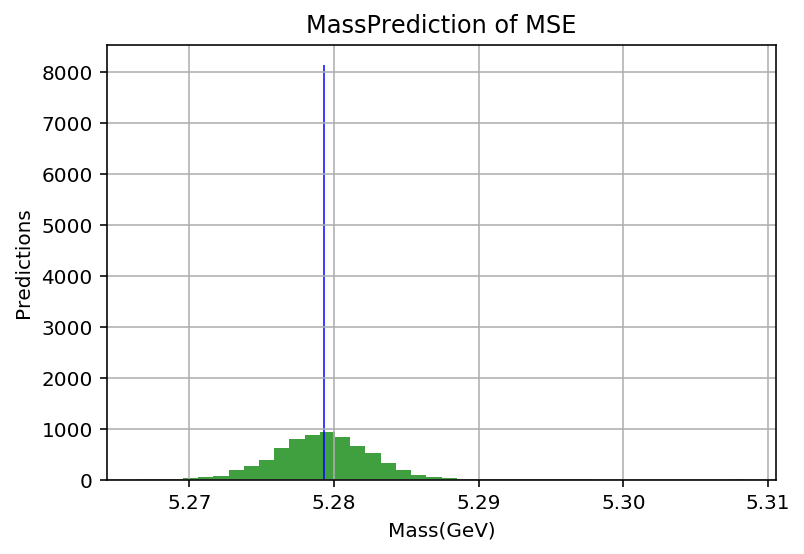

In [22]:
PlotPrediction('test.txt','predictions/Mass_200epPre.png','Mass')

In [23]:
def PlotWithoutModel(filepath, fig, tag):
    TrueMass = 5.27933
    with open(filepath, 'r') as file:
        lines = file.readlines()
    masses = []
    for line in lines:
        masses.append(float(line))
    plt.hist(masses, 40, label='prediction', density=False, color = 'g', alpha = 0.75)
    # Mark True mass
    plt.axvline(TrueMass, color='red', linestyle='--', label='Marked Point')
    
    plt.xlabel(tag+'(GeV)')
    plt.ylabel('Predictions')
    plt.title(tag+'Prediction of MSE')
    plt.grid(True)
    plt.savefig(fig)

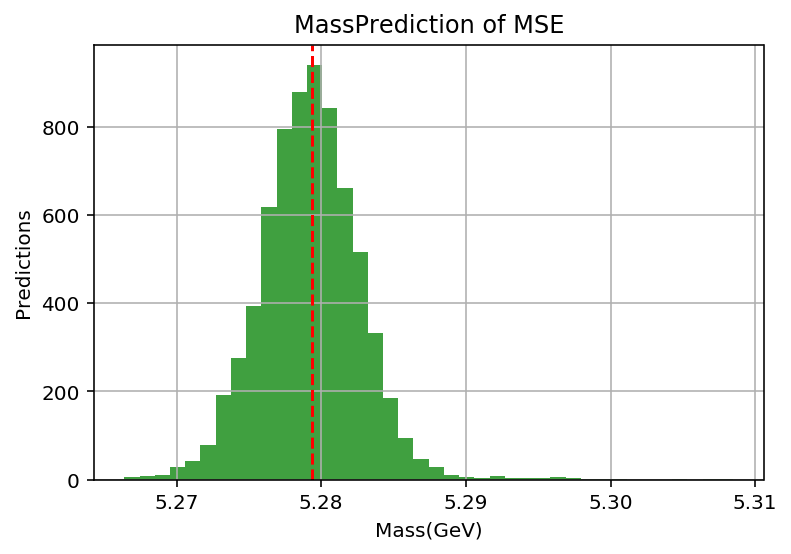

In [24]:
PlotWithoutModel('200pre_MEPoint.txt', '200masspre.png', 'Mass')